In [2]:
import tensorflow as tf

print(f"TensorFlow {tf.__version__}")
print(f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
    print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

TensorFlow 2.7.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


import seaborn as sns

#import xgboost as xgb
#import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

import matplotlib.pyplot as plt

In [4]:
raw_df = pd.read_csv("./heart.csv")
raw_df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler

ct_MM = make_column_transformer(
    (MinMaxScaler(), ["age", "trtbps", "chol", "thalachh", "oldpeak", "slp", "caa", "thall"])
    )

first_half = ct_MM.fit_transform(raw_df)
first_half = pd.DataFrame(first_half)
first_half.rename(columns={0: "age", 1: "trtbps", 2: "chol", 3: "thalachh", 4: "oldpeak", 5: "slp", 6: "caa", 7: "thall"}, inplace=True)
raw_df_MM = pd.concat([first_half, raw_df[["sex", "exng", "cp", "fbs", "restecg", "output"]]], join="inner", axis=1)
raw_df_MM

,age,trtbps,chol,thalachh,oldpeak,slp,caa,thall,sex,exng,cp,fbs,restecg,output
0,0.708333,0.481132,0.244292,0.603053,0.370968,0.0,0.00,0.333333,1,0,3,1,0,1
1,0.166667,0.339623,0.283105,0.885496,0.564516,0.0,0.00,0.666667,1,0,2,0,1,1
2,0.250000,0.339623,0.178082,0.770992,0.225806,1.0,0.00,0.666667,0,0,1,0,0,1
3,0.562500,0.245283,0.251142,0.816794,0.129032,1.0,0.00,0.666667,1,0,1,0,1,1
4,0.583333,0.245283,0.520548,0.702290,0.096774,1.0,0.00,0.666667,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,0.583333,0.433962,0.262557,0.396947,0.032258,0.5,0.00,1.000000,0,1,0,0,1,0
299,0.333333,0.150943,0.315068,0.465649,0.193548,0.5,0.00,1.000000,1,0,3,0,1,0
300,0.812500,0.471698,0.152968,0.534351,0.548387,0.5,0.50,1.000000,1,0,0,1,1,0
301,0.583333,0.339623,0.011416,0.335878,0.193548,0.5,0.25,1.000000,1,1,0,0,1,0


In [6]:
raw_df_NN = pd.get_dummies(raw_df, columns = ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall'])
standardScaler = StandardScaler()
columns_to_scale = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']

# raw_df_NN[columns_to_scale] = standardScaler.fit_transform(raw_df_NN[columns_to_scale])

x_raw = raw_df.drop(columns="output").to_numpy()
y_raw = raw_df['output'].to_numpy()
X_train,X_test,y_train,y_test=train_test_split(x_raw,y_raw,test_size=0.3,random_state=88)
X_train,X_test,y_train,y_test = X_train,X_test,y_train,y_test

In [7]:
x_raw = raw_df_MM.drop(columns="output").to_numpy()
y_raw = raw_df_MM['output'].to_numpy()
X_train,X_test,y_train,y_test=train_test_split(x_raw,y_raw,test_size=0.3,random_state=88)
X_train,X_test,y_train,y_test = X_train,X_test,y_train,y_test

In [8]:
np.random.seed(88)
tf.random.set_seed(88)

In [9]:
input_dim = X_train.shape[1]
output_dim = 1

print(f'Input Dimension: {input_dim}\nOutput Dimension: {output_dim}')

Input Dimension: 13
Output Dimension: 1


In [10]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

In [11]:
tf.random.set_seed(88)

model = tf.keras.models.Sequential()

model.add(tf.keras.Input(shape=(input_dim,)))

model.add(tf.keras.layers.Dense(100, activation='relu', name='hidden1'))
model.add(tf.keras.layers.BatchNormalization(axis=1, name='bn1'))
model.add(tf.keras.layers.Dense(200, activation='relu', name='hidden2'))
model.add(tf.keras.layers.BatchNormalization(axis=1, name='bn2'))
model.add(tf.keras.layers.Dense(100, activation='relu', name='hidden3'))
model.add(tf.keras.layers.BatchNormalization(axis=1, name='bn3'))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Dense(output_dim, activation='sigmoid', name="output"))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1 (Dense)             (None, 100)               1400      
                                                                 
 bn1 (BatchNormalization)    (None, 100)               400       
                                                                 
 hidden2 (Dense)             (None, 200)               20200     
                                                                 
 bn2 (BatchNormalization)    (None, 200)               800       
                                                                 
 hidden3 (Dense)             (None, 100)               20100     
                                                                 
 bn3 (BatchNormalization)    (None, 100)               400       
                                                                 
 dropout (Dropout)           (None, 100)               0

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate = 0.001), 
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                metrics=['acc']
                )

checkpoint_filepath = "bestmodel_epoch{epoch:02d}_valloss{val_loss:.2f}.hdf5"
callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                save_weights_only=True,
                                                                monitor='val_acc',
                                                                mode='max',
                                                                save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=100, verbose=1, validation_split=0.2, callbacks=[callback])

results = model.evaluate(X_test, y_test, batch_size = 128)
print(f"{model.metrics_names} = {results}")

Epoch 1/100
2/2 [==============================] - 1s 150ms/step - loss: 1.0513 - acc: 0.4320 - val_loss: 0.6518 - val_acc: 0.6279
Epoch 2/100
2/2 [==============================] - 0s 24ms/step - loss: 0.6261 - acc: 0.7337 - val_loss: 0.6476 - val_acc: 0.6279
Epoch 3/100
2/2 [==============================] - 0s 35ms/step - loss: 0.4716 - acc: 0.8284 - val_loss: 0.6473 - val_acc: 0.7674
Epoch 4/100
2/2 [==============================] - 0s 35ms/step - loss: 0.4326 - acc: 0.8047 - val_loss: 0.6478 - val_acc: 0.7907
Epoch 5/100
2/2 [==============================] - 0s 33ms/step - loss: 0.3531 - acc: 0.8580 - val_loss: 0.6491 - val_acc: 0.8372
Epoch 6/100
2/2 [==============================] - 0s 21ms/step - loss: 0.3323 - acc: 0.8698 - val_loss: 0.6494 - val_acc: 0.8140
Epoch 7/100
2/2 [==============================] - 0s 22ms/step - loss: 0.2704 - acc: 0.8639 - val_loss: 0.6486 - val_acc: 0.8140
Epoch 8/100
2/2 [==============================] - 0s 23ms/step - loss: 0.3020 - acc: 0.8

In [13]:
from keras.callbacks import LearningRateScheduler

In [14]:
initial_lr = 0.0014
decay_rate = 0.0013
def exp_decay(epoch):
    lrate = initial_lr * np.exp(-decay_rate * epoch)
    return lrate
lrs = LearningRateScheduler(exp_decay)
callback = [lrs]

Epoch 1/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6269 - accuracy: 0.7406 - lr: 0.0014
Epoch 2/100
7/7 [==============================] - 0s 4ms/step - loss: 0.5497 - accuracy: 0.7877 - lr: 0.0014
Epoch 3/100
7/7 [==============================] - 0s 3ms/step - loss: 0.5034 - accuracy: 0.8019 - lr: 0.0014
Epoch 4/100
7/7 [==============================] - 0s 4ms/step - loss: 0.4654 - accuracy: 0.8019 - lr: 0.0014
Epoch 5/100
7/7 [==============================] - 0s 3ms/step - loss: 0.4362 - accuracy: 0.8160 - lr: 0.0014
Epoch 6/100
7/7 [==============================] - 0s 4ms/step - loss: 0.4074 - accuracy: 0.8443 - lr: 0.0014
Epoch 7/100
7/7 [==============================] - 0s 3ms/step - loss: 0.3852 - accuracy: 0.8349 - lr: 0.0014
Epoch 8/100
7/7 [==============================] - 0s 4ms/step - loss: 0.3717 - accuracy: 0.8396 - lr: 0.0014
Epoch 9/100
7/7 [==============================] - 0s 3ms/step - loss: 0.3524 - accuracy: 0.8302 - lr: 0.0014
Epoch 10/1

<AxesSubplot:xlabel='epochs'>

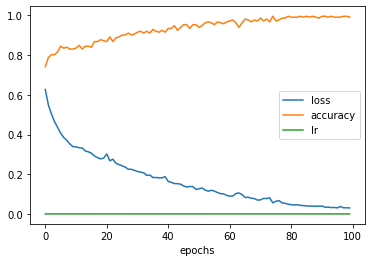

In [15]:
tf.random.set_seed(88)

model_1 = tf.keras.Sequential([
                     tf.keras.layers.Dense(40, activation="relu"),
                     tf.keras.layers.Dense(75, activation="relu"),
                     tf.keras.layers.Dense(60, activation="relu"),
                     tf.keras.layers.Dense(1, activation="sigmoid")
])


model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                metrics=["accuracy"])



history_1 = model_1.fit(X_train, y_train,  epochs=100, callbacks=callback)

results_1 = model_1.evaluate(X_test, y_test, batch_size = 128)
print(f"{model_1.metrics_names} = {results_1}")

pd.DataFrame(history_1.history).plot(xlabel='epochs', figsize=(6,4))

In [16]:
tf.random.set_seed(88)

model_2 = tf.keras.models.Sequential()

model_2.add(tf.keras.Input(shape=(input_dim,)))

model_2.add(tf.keras.layers.Dense(40, activation='relu', name='hidden1'))
model_2.add(tf.keras.layers.Dense(75, activation='relu', name='hidden2'))
model_2.add(tf.keras.layers.Dense(60, activation='relu', name='hidden3'))

model_2.add(tf.keras.layers.Dense(output_dim, activation='sigmoid', name="output"))

model_2.summary()

model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adamax(learning_rate = 0.0001),
                metrics=["accuracy"])

checkpoint_filepath = "bestmodel_epoch{epoch:02d}_valloss{val_loss:.2f}.hdf5"
callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                save_weights_only=True,
                                                                monitor='val_acc',
                                                                mode='max',
                                                                save_best_only=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1 (Dense)             (None, 40)                560       
                                                                 
 hidden2 (Dense)             (None, 75)                3075      
                                                                 
 hidden3 (Dense)             (None, 60)                4560      
                                                                 
 output (Dense)              (None, 1)                 61        
                                                                 
Total params: 8,256
Trainable params: 8,256
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
2/2 [==============================] - 0s 88ms/step - loss: 0.6481 - accuracy: 0.7101 - val_loss: 0.6292 - val_accuracy: 0.8372
Epoch 2/100
2/2 [==============================] - 0s 17ms/step - loss: 0.6461 - accuracy: 0.7337 - val_loss: 0.6272 - val_accuracy: 0.8372
Epoch 3/100
2/2 [==============================] - 0s 35ms/step - loss: 0.6444 - accuracy: 0.7456 - val_loss: 0.6253 - val_accuracy: 0.8372
Epoch 4/100
2/2 [==============================] - 0s 19ms/step - loss: 0.6428 - accuracy: 0.7515 - val_loss: 0.6237 - val_accuracy: 0.8372
Epoch 5/100
2/2 [==============================] - 0s 24ms/step - loss: 0.6412 - accuracy: 0.7574 - val_loss: 0.6222 - val_accuracy: 0.8372
Epoch 6/100
2/2 [==============================] - 0s 30ms/step - loss: 0.6399 - accuracy: 0.7633 - val_loss: 0.6208 - val_accuracy: 0.8372
Epoch 7/100
2/2 [==============================] - 0s 35ms/step - loss: 0.6387 - accuracy: 0.7692 - val_loss: 0.6194 - val_accuracy: 0.8372
Epoch 8/100
2/2 [===

<AxesSubplot:xlabel='epochs'>

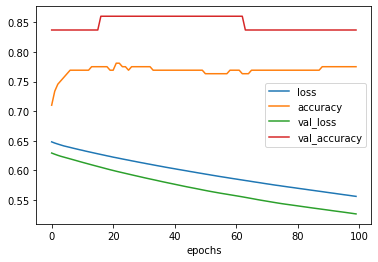

In [17]:
history_2 = model_2.fit(X_train, y_train, batch_size=128, epochs=100, verbose=1, validation_split=0.2, callbacks=[callback])


results_2 = model_2.evaluate(X_test, y_test, batch_size = 128)
print(f"{model_2.metrics_names} = {results_2}")

pd.DataFrame(history_2.history).plot(xlabel='epochs', figsize=(6,4))

In [18]:
tf.random.set_seed(88)

model_3 = tf.keras.models.Sequential()

model_3.add(tf.keras.Input(shape=(input_dim,)))

model_3.add(tf.keras.layers.Dense(500, activation='relu', name='hidden1'))
model_3.add(tf.keras.layers.Dense(200, activation='relu', name='hidden2'))
model_3.add(tf.keras.layers.Dense(500, activation='relu', name='hidden3'))
#model_3.add(tf.keras.layers.BatchNormalization(axis=1, name='bn3'))
#model_3.add(tf.keras.layers.Dropout(0.3))

model_3.add(tf.keras.layers.Dense(output_dim, activation='sigmoid', name="output"))

model_3.summary()

model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adamax(learning_rate = 0.0001),
                metrics=["accuracy"])

checkpoint_filepath = "bestmodel_epoch{epoch:02d}_valloss{val_loss:.2f}.hdf5"
callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                save_weights_only=True,
                                                                monitor='val_acc',
                                                                mode='max',
                                                                save_best_only=True)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1 (Dense)             (None, 500)               7000      
                                                                 
 hidden2 (Dense)             (None, 200)               100200    
                                                                 
 hidden3 (Dense)             (None, 500)               100500    
                                                                 
 output (Dense)              (None, 1)                 501       
                                                                 
Total params: 208,201
Trainable params: 208,201
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
2/2 [==============================] - 0s 97ms/step - loss: 0.6979 - accuracy: 0.3964 - val_loss: 0.6863 - val_accuracy: 0.6977
Epoch 2/100
2/2 [==============================] - 0s 43ms/step - loss: 0.6890 - accuracy: 0.5917 - val_loss: 0.6765 - val_accuracy: 0.8372
Epoch 3/100
2/2 [==============================] - 0s 74ms/step - loss: 0.6818 - accuracy: 0.6568 - val_loss: 0.6680 - val_accuracy: 0.8372
Epoch 4/100
2/2 [==============================] - 0s 61ms/step - loss: 0.6757 - accuracy: 0.6923 - val_loss: 0.6606 - val_accuracy: 0.8372
Epoch 5/100
2/2 [==============================] - 0s 19ms/step - loss: 0.6697 - accuracy: 0.7041 - val_loss: 0.6545 - val_accuracy: 0.8372
Epoch 6/100
2/2 [==============================] - 0s 19ms/step - loss: 0.6651 - accuracy: 0.7101 - val_loss: 0.6484 - val_accuracy: 0.8605
Epoch 7/100
2/2 [==============================] - 0s 22ms/step - loss: 0.6605 - accuracy: 0.7278 - val_loss: 0.6425 - val_accuracy: 0.8605
Epoch 8/100
2/2 [===

<AxesSubplot:xlabel='epochs'>

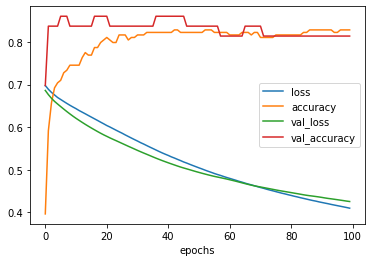

In [27]:
history_3 = model_3.fit(X_train, y_train, batch_size=128, epochs=100, verbose=1, validation_split=0.2, callbacks=[callback])


results_3 = model_3.evaluate(X_test, y_test, batch_size = 128)
print(f"{model_3.metrics_names} = {results_3}")

pd.DataFrame(history_3.history).plot(xlabel='epochs', figsize=(6,4))

In [19]:
tf.random.set_seed(88)

model_4 = tf.keras.models.Sequential()

model_4.add(tf.keras.Input(shape=(input_dim,)))

model_4.add(tf.keras.layers.Dense(800, activation='relu', name='hidden1'))
model_4.add(tf.keras.layers.Dense(200, activation='relu', name='hidden2'))
model_4.add(tf.keras.layers.Dense(600, activation='relu', name='hidden3'))

model_4.add(tf.keras.layers.Dense(output_dim, activation='sigmoid', name="output"))

model_4.summary()

model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adamax(learning_rate = 0.0001),
                metrics=["accuracy"])

checkpoint_filepath = "bestmodel_epoch{epoch:02d}_valloss{val_loss:.2f}.hdf5"
callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                save_weights_only=True,
                                                                monitor='val_acc',
                                                                mode='max',
                                                                save_best_only=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1 (Dense)             (None, 800)               11200     
                                                                 
 hidden2 (Dense)             (None, 200)               160200    
                                                                 
 hidden3 (Dense)             (None, 600)               120600    
                                                                 
 output (Dense)              (None, 1)                 601       
                                                                 
Total params: 292,601
Trainable params: 292,601
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
2/2 [==============================] - 0s 88ms/step - loss: 0.6890 - accuracy: 0.5325 - val_loss: 0.6712 - val_accuracy: 0.6279
Epoch 2/100
2/2 [==============================] - 0s 18ms/step - loss: 0.6802 - accuracy: 0.5325 - val_loss: 0.6621 - val_accuracy: 0.6279
Epoch 3/100
2/2 [==============================] - 0s 20ms/step - loss: 0.6731 - accuracy: 0.5325 - val_loss: 0.6539 - val_accuracy: 0.6977
Epoch 4/100
2/2 [==============================] - 0s 18ms/step - loss: 0.6668 - accuracy: 0.5976 - val_loss: 0.6466 - val_accuracy: 0.7209
Epoch 5/100
2/2 [==============================] - 0s 19ms/step - loss: 0.6606 - accuracy: 0.6450 - val_loss: 0.6405 - val_accuracy: 0.7674
Epoch 6/100
2/2 [==============================] - 0s 18ms/step - loss: 0.6557 - accuracy: 0.6864 - val_loss: 0.6346 - val_accuracy: 0.7674
Epoch 7/100
2/2 [==============================] - 0s 18ms/step - loss: 0.6509 - accuracy: 0.7101 - val_loss: 0.6286 - val_accuracy: 0.7907
Epoch 8/100
2/2 [===

<AxesSubplot:xlabel='epochs'>

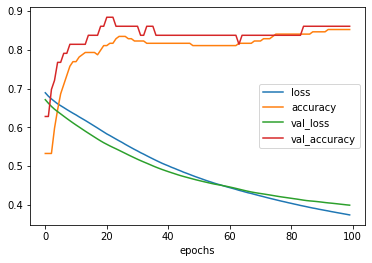

In [20]:
history_4 = model_4.fit(X_train, y_train, batch_size=128, epochs=100, verbose=1, validation_split=0.2, callbacks=[callback])


results_4 = model_4.evaluate(X_test, y_test, batch_size = 128)
print(f"{model_4.metrics_names} = {results_4}")

pd.DataFrame(history_4.history).plot(xlabel='epochs', figsize=(6,4))

Epoch 1/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6033 - accuracy: 0.6462 - lr: 0.0014
Epoch 2/100
7/7 [==============================] - 0s 5ms/step - loss: 0.4599 - accuracy: 0.8255 - lr: 0.0014
Epoch 3/100
7/7 [==============================] - 0s 5ms/step - loss: 0.4396 - accuracy: 0.8160 - lr: 0.0014
Epoch 4/100
7/7 [==============================] - 0s 4ms/step - loss: 0.4010 - accuracy: 0.8208 - lr: 0.0014
Epoch 5/100
7/7 [==============================] - 0s 5ms/step - loss: 0.3672 - accuracy: 0.8396 - lr: 0.0014
Epoch 6/100
7/7 [==============================] - 0s 4ms/step - loss: 0.3474 - accuracy: 0.8349 - lr: 0.0014
Epoch 7/100
7/7 [==============================] - 0s 4ms/step - loss: 0.3192 - accuracy: 0.8774 - lr: 0.0014
Epoch 8/100
7/7 [==============================] - 0s 4ms/step - loss: 0.3058 - accuracy: 0.8585 - lr: 0.0014
Epoch 9/100
7/7 [==============================] - 0s 4ms/step - loss: 0.2807 - accuracy: 0.8915 - lr: 0.0014
Epoch 10/1

<AxesSubplot:xlabel='epochs'>

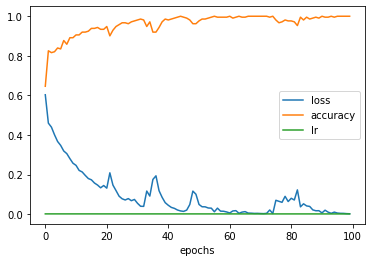

In [21]:
tf.random.set_seed(88)

model_5 = tf.keras.Sequential([
                     tf.keras.layers.Dense(800, activation="relu"),
                     tf.keras.layers.Dense(200, activation="relu"),
                     tf.keras.layers.Dense(600, activation="relu"),
                     tf.keras.layers.Dense(1, activation="sigmoid")
])


model_5.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                metrics=["accuracy"])



history_5 = model_5.fit(X_train, y_train,  epochs=100, callbacks=[lrs])

results_5 = model_5.evaluate(X_test, y_test, batch_size = 128)
print(f"{model_5.metrics_names} = {results_5}")

pd.DataFrame(history_5.history).plot(xlabel='epochs', figsize=(6,4))

1/1 [==============================] - 0s 59ms/step - loss: 1.2652 - accuracy: 0.5275
['loss', 'accuracy'] = [1.265244722366333, 0.5274725556373596]


<AxesSubplot:xlabel='epochs'>

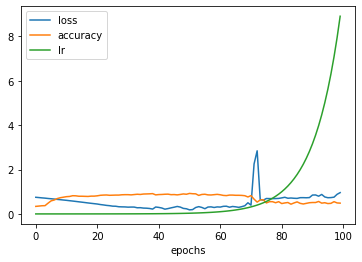

In [22]:
tf.random.set_seed(88)

model_6 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_6.compile(loss=tf.keras.losses.binary_crossentropy,
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

# Create a learning rate callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

history_6 = model_6.fit(X_train, y_train, epochs=100, callbacks=[lr_scheduler], verbose=0)

results_6 = model_6.evaluate(X_test, y_test, batch_size = 128)
print(f"{model_6.metrics_names} = {results_6}")

pd.DataFrame(history_6.history).plot(xlabel='epochs', figsize=(6,4))

1/1 [==============================] - 0s 60ms/step - loss: 0.5814 - accuracy: 0.8901
['loss', 'accuracy'] = [0.5814245343208313, 0.8901098966598511]


<AxesSubplot:xlabel='epochs'>

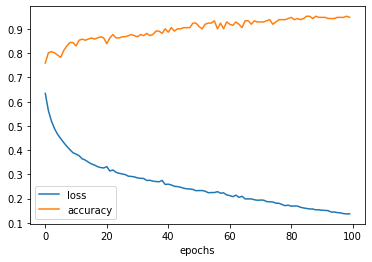

In [23]:
tf.random.set_seed(88)

model_7 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_7.compile(loss=tf.keras.losses.binary_crossentropy,
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy'])

history_7 = model_7.fit(X_train, y_train, epochs=100, verbose=0)

results_7 = model_7.evaluate(X_test, y_test, batch_size = 128)
print(f"{model_7.metrics_names} = {results_7}")

pd.DataFrame(history_7.history).plot(xlabel='epochs', figsize=(6,4))

2/2 [==============================] - 0s 2ms/step - loss: 0.5417 - accuracy: 0.8901
['loss', 'accuracy'] = [0.5417405366897583, 0.8901098966598511]


<AxesSubplot:xlabel='epochs'>

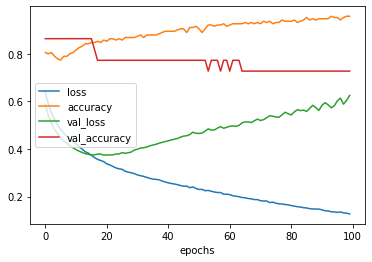

In [24]:
tf.random.set_seed(88)

model_8 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_8.compile(loss=tf.keras.losses.binary_crossentropy,
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy'])

history_8 = model_8.fit(X_train, y_train, epochs=100, verbose=0, batch_size = 64, validation_split=0.1)

results_8 = model_8.evaluate(X_test, y_test, batch_size = 64)
print(f"{model_8.metrics_names} = {results_8}")

pd.DataFrame(history_8.history).plot(xlabel='epochs', figsize=(6,4))

In [28]:
print(f"0 {model_1.metrics_names} = {results}")
print(f"1 {model_1.metrics_names} = {results_1}")
print(f"2 {model_2.metrics_names} = {results_2}")
print(f"3 {model_3.metrics_names} = {results_3}")
print(f"4 {model_4.metrics_names} = {results_4}")
print(f"5 {model_5.metrics_names} = {results_5}")
print(f"6 {model_6.metrics_names} = {results_6}")
print(f"7 {model_7.metrics_names} = {results_7}")
print(f"8 {model_8.metrics_names} = {results_8}")
#print(f"9 {model_9.metrics_names} = {results_9}")

0 ['loss', 'accuracy'] = [0.4877419173717499, 0.791208803653717]
1 ['loss', 'accuracy'] = [1.0374794006347656, 0.8461538553237915]
2 ['loss', 'accuracy'] = [0.5537063479423523, 0.7802197933197021]
3 ['loss', 'accuracy'] = [0.42692142724990845, 0.8461538553237915]
4 ['loss', 'accuracy'] = [0.4108806252479553, 0.8131868243217468]
5 ['loss', 'accuracy'] = [1.705619215965271, 0.8791208863258362]
6 ['loss', 'accuracy'] = [1.265244722366333, 0.5274725556373596]
7 ['loss', 'accuracy'] = [0.5814245343208313, 0.8901098966598511]
8 ['loss', 'accuracy'] = [0.5417405366897583, 0.8901098966598511]


raw_df_NN
[0 ['loss', 'accuracy'] = [0.44134441018104553, 0.8131868243217468]
1 ['loss', 'accuracy'] = [1.611944317817688, 0.8571428656578064]
2 ['loss', 'accuracy'] = [0.5438063740730286, 0.8241758346557617]
3 ['loss', 'accuracy'] = [0.38474905490875244, 0.8571428656578064]
4 ['loss', 'accuracy'] = [0.4245511591434479, 0.8461538553237915]
5 ['loss', 'accuracy'] = [2.442267417907715, 0.8351648449897766]
6 ['loss', 'accuracy'] = [1.2862541675567627, 0.5274725556373596]
7 ['loss', 'accuracy'] = [1.5228493213653564, 0.8131868243217468]
8 ['loss', 'accuracy'] = [1.2029632329940796, 0.8461538553237915]

raw_df_MM
0 ['loss', 'accuracy'] = [0.48921123147010803, 0.791208803653717]
1 ['loss', 'accuracy'] = [1.069010615348816, 0.8351648449897766]
2 ['loss', 'accuracy'] = [0.5537063479423523, 0.7802197933197021]
3 ['loss', 'accuracy'] = [0.4269130527973175, 0.8461538553237915]
4 ['loss', 'accuracy'] = [0.41102510690689087, 0.8241758346557617]
5 ['loss', 'accuracy'] = [2.0000765323638916, 0.8791208863258362]
6 ['loss', 'accuracy'] = [1.2499765157699585, 0.5274725556373596]
7 ['loss', 'accuracy'] = [0.5811523795127869, 0.8901098966598511]
8 ['loss', 'accuracy'] = [0.5426582098007202, 0.8901098966598511]


In [29]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

In [30]:
predictions = tf.round(model_7.predict(X_test)).numpy().flatten()
print(classification_report(y_test, predictions))

pd.DataFrame(confusion_matrix(y_test,predictions,), columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])

              precision    recall  f1-score   support

           0       0.87      0.91      0.89        43
           1       0.91      0.88      0.89        48

    accuracy                           0.89        91
   macro avg       0.89      0.89      0.89        91
weighted avg       0.89      0.89      0.89        91



,Predicted Negative,Predicted Positive
Actual Negative,39,4
Actual Positive,6,42


In [31]:
cf_mx=confusion_matrix(y_test,predictions,)
true_negative  = cf_mx[0][0]
false_positive = cf_mx[0][1]
false_negative = cf_mx[1][0]
true_positive  = cf_mx[1][1]

predicted_negative = true_negative + false_negative
predicted_positive = false_positive + true_positive 
actual_positive = false_negative + true_positive
actual_negative = true_negative + false_positive

accuracy = (true_positive + true_negative) / (predicted_negative + predicted_positive)
precision = true_positive / predicted_positive
recall = true_positive / actual_positive
f1 = 2 * precision * recall / (precision + recall) 

print('Accuracy:', accuracy, 'Precision:', precision, 'Recall:', recall, 'F1:', f1)

Accuracy: 0.8901098901098901 Precision: 0.9130434782608695 Recall: 0.875 F1: 0.8936170212765957


In [32]:
predictions = tf.round(model.predict(X_test)).numpy().flatten()
accuracy_score(y_test, predictions)

0.7912087912087912